# Justin's Tools for Querying Calibration and Reference Star Targets
These tools utilize astroquery to query Simbad and VizieR (coming soon!) for collecting information for both specific targets and identifying possible targets that satisfy some sort of criteria.

First, import the relevant packages.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad
import time
import astropy.units as u
from astropy.coordinates import SkyCoord
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch,Rectangle
from astropy.coordinates import HeliocentricTrueEcliptic
from astropy.coordinates import HeliocentricMeanEcliptic
from astropy.coordinates import Galactic
from astropy.coordinates import ICRS
from astropy.time import Time as astroTime

Next, customize some of the Simbad query settings. Check out https://simbad.u-strasbg.fr/simbad/tap/tapsearch.html for a guide on all votable fields in astroquery Simbad queries.

In [5]:
simbad = Simbad()
simbad.add_votable_fields("pmra",
							"pmdec",
							"sp_type",
							"V",
							"G",
							"I",
							"H",
							"plx_value",
							"rvz_radvel")

# Tutorial for Identifying Candidate Targets based on a set of Selection Criteria

If you need to find targets that satisfy some sort of specific reference criteria, the easiest thing to do is to query the TAP service. To do this, you construct a string of your ADQL TAP query, and can then use astroquery's queryTap function to make the query. Using ADQL (Astronomy Data Query Language) allows you to specifically optimize your query.

Many of the Roman-Coronagraph calibration target criteria are related to target magnitudes, so let's construct a function that can query Simbad based off of some magnitude criteria. For Roman, we also want to avoid binaries/double stars to the best of our ability. We also want to avoid variable stars particularly if we want to identify potential flux standards. While variable stars come in many forms, it's easiest to just avoid any object that may be considered a variable star (and double stars) regardless of how much of an impact the properties may have on performing actual calibrations. In this next cell, I'll give the function I create that queries Simbad for targets based off the following criteria:

Has a V magnitude within a certain range of a target V magnitude

Is not classified as a variable star (V*) or a double star (**). ADQL queries are verbose, so I'll go through each line to explain what each step is doing.

In [23]:
def queryTap_byVmag(Vmag,cone=0.1):
    #"""
    #Queries Simbad using the ADQL TAP service for stars that are within a certain Vmag of Vmag and are not double and/or variable stars.
    #Inputs:
    #    Vmag: Target V magnitude you want to query for
    #    cone: (Default=0.1), cone in which magnitudes within Vmag+/-cone are acceptable to query
    #Returns:
    #    Simbad query result in the form of an astropy table. The columns of the table have the properties of each target, each row is an individual target from the query result.
    #"""
	example_base = """SELECT TOP 50 oid, main_id, ra, dec, pmra, pmdec, plx_value, rvz_radvel, otype, V, otypes
						FROM basic JOIN allfluxes ON basic.oid = allfluxes.oidref JOIN alltypes ON basic.oid = alltypes.oidref
						WHERE (otype = '*') AND (otype != 'V*..') AND (otype != '**..') AND (V <= {VmagUp}) AND (V >= {VmagDown})
						AND (otypes) NOT LIKE ('%V*%')
						AND (otypes) NOT LIKE ('%**%')
                        AND (otypes) NOT LIKE ('%EB?%')
  						AND ra IS NOT NULL
  						AND dec IS NOT NULL
                        AND plx_value IS NOT NULL
                        AND pmra IS NOT NULL
                        AND pmdec IS NOT NULL
                        AND rvz_radvel IS NOT NULL
  						ORDER BY V;"""
    #^This is the query string that will do everything! In the next markdown cell I'll break done each component and explain how it works
	example = example_base.format(VmagUp=str(Vmag+cone),VmagDown=str(Vmag-cone)) #This line takes your input Vmag and cone and converts the values into strings that are inserted in the query string.

	queryresult = simbad.query_tap(example) #This step performs the query!

	return queryresult #Return your query result

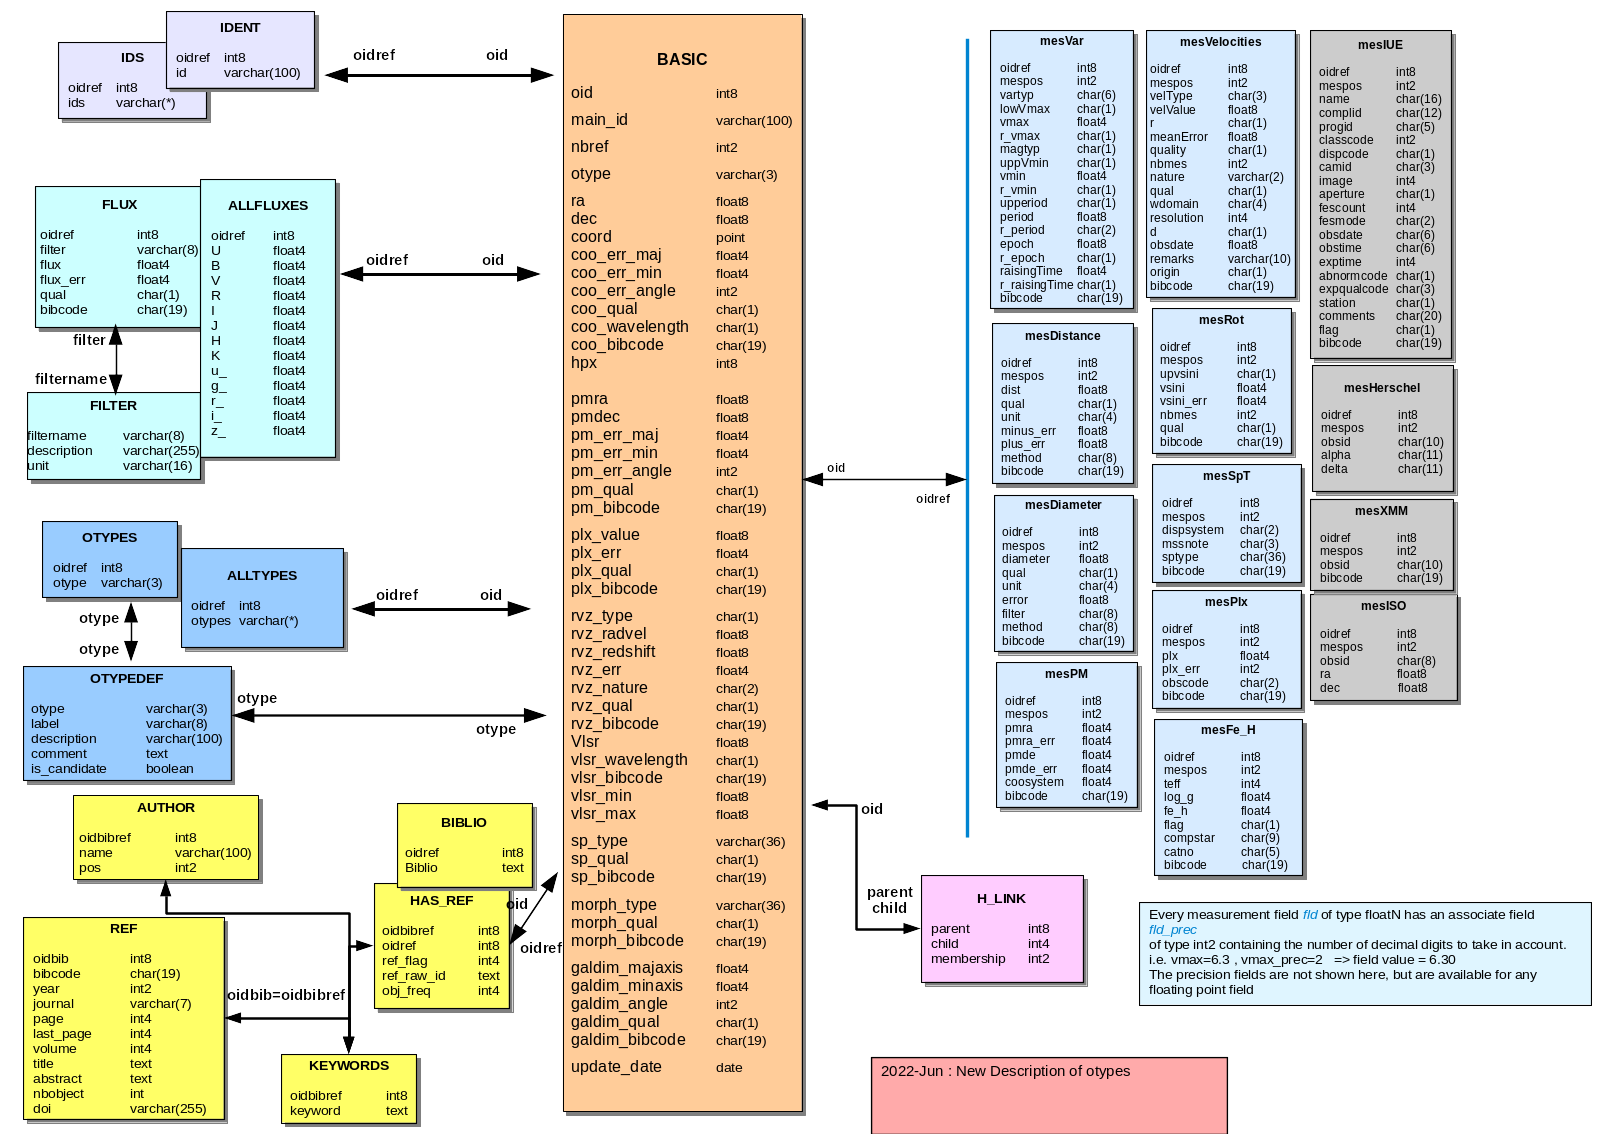

(image credit, Simbad website)
I'm going to break down each step/line of the query string so that it makes sense

**SELECT TOP 50** - This is a command saying to output up to 50 possible targets. Note that this is not sorted in some preferrential way... that involves some additional ADQL language.

**oid, main_id, ra, dec, pmra, pmdec, plx_value, rvz_radvel, otype, V, otypes** - These are the names of the columns or keywords you are querying, following the names described here: https://simbad.u-strasbg.fr/simbad/tap/tapsearch.html



If you follow the link (or view the chart above), you'll notice how keywords are categorized. By default, unless specified, you will only have access to the "BASIC" category of keywords. This means that unless you JOIN tables, trying to query keywords not in the BASIC table will cause your query to fail. In the above example, all of these keywords are in the "BASIC" table except for "otype," "V," and "otypes." Joining tables is the next line.

**FROM basic JOIN allfluxes ON basic.oid = allfluxes.oidref JOIN alltypes ON basic.oid = alltypes.oidref** - This line says to join multiple keyword tables together. You need to join each table separately.

"allfluxes" has the "V" keyword we want, so we JOIN allfluxes to basic. But how do we know how to link the two tables together? This is where ON comes in. The arrows linking the different keyword tables all have some common keyword that is common to both tables, but that keyword does not necessarily have the same name in each table. In the case of "allfluxes" and "basic", the "oid" keyword from "basic" is the same as the "oidref" keyword from "allfluxes." Therefore,

FROM basic JOIN allfluxes ON basic.oid = allfluxes.oidref

says to join "basic" and "allfluxes" by linking the basic.oid keyword to the allfluxes.oidref keyword. If we want to join multiple keyword tables to "basic," we repeat the commands with JOIN and ON again. So in this line, we're saying JOIN "allfluxes" to "basic" using the basic.oid keyword and allfluxes.oidref keyword and also JOIN "alltypes" to "basic" using the basic.oid and alltypes.oidref keywords

At this point, we have established what keywords (properties) we want to query. From this point onwards, we now input the query criteria, starting with "WHERE". Each criteria can only be described one at a time, and separated with "AND". In our example criteria:

**WHERE (otype = '*') AND** - We want (=) the object type to be a star, or "*"

**(otype != 'V(asterisk)..') AND** - We do not want (!=) to be the primary object type to be a variable star or "V*"

**(otype != '(asterisk)(asterisk)..') AND** - We do not want the primary object type to be a double star

**(V <= {VmagUp}) AND** - We want the object V magnitude to be lower than VmagUp, which is a customizable input

**(V >= {VmagDown}) AND** - We want the object V magnitude to be higher than Vmag Down, again a customizable input

**(otypes) NOT LIKE ('%V(asterisk)%') AND** - Just because we excluded objects where the primary type is a variable star, it doesn't mean we have excluded all variable stars. This means that in the list of other object types (otypes), we don't want 'V*' to show up there. This is denoted with % on either side to represent wildcards.

**(otypes) NOT LIKE ('%(asterisk)(asterisk)%') AND** - Same with the double stars.

**ra IS NOT NULL AND** - make sure there are actually coordinates

**dec IS NOT NULL**

**ORDER BY V;** - order the results by V magnitude

This page that describes the abbreviations for different Simbad otypes is also useful: https://simbad.cds.unistra.fr/guide/otypes.htx

And that's it! Let's try it out.

In [24]:
queryTap_byVmag(10.5)

oid,main_id,ra,dec,pmra,pmdec,plx_value,rvz_radvel,otype,V,otypes
,,deg,deg,mas / yr,mas / yr,mas,km / s,,,
int64,object,float64,float64,float64,float64,float64,float64,object,float64,object
1947655,CD-32 8768,188.00306800967996,-32.82818214302,4.806,-1.178,1.3355,-13.95,*,10.401000022888184,*|NIR
3148150,TYC 8948-771-1,137.58071579521,-65.5052509528,1.075,9.427,0.787,84.37,*,10.401000022888184,*|NIR
2995402,TYC 8141-1363-1,113.83006054255002,-49.274774158830006,-2.996,-1.786,0.9377,-4.29,*,10.401000022888184,*|NIR
3356821,CD-45 14951,347.7345354634,-44.61086747932001,-15.736,-30.299,7.2621,-1.01,*,10.401000022888184,*|NIR
7278372,TYC 6531-765-1,104.82099699248,-27.11508697791,2.187,-6.443,1.238,33.94,*,10.401000022888184,*|NIR|RG*
3318156,TYC 9431-2190-1,211.68626419805,-77.13539379458,-31.09,-14.611,1.9142,53.22,*,10.401000022888184,*|NIR
11580153,CD-41 8851,217.95078669839,-41.77057993432,8.908,0.555,1.3085,12.47,*,10.401000022888184,*|NIR
2976691,CD-43 3890,121.03483142368,-43.41431566386,-10.228,8.736,0.7217,-3.09,*,10.401000022888184,*|NIR


So we have our astropy table now of 50 targets that satisfy our selection criteria. Note that if you run this query again, you may not get the exact same 50 targets as before. This is because the TAP query is just identifying from its database a set of 50 targets that **exactly** satisfy the criteria you gave it, and as soon as it finds 50, it stops. Therefore, if there are more than 50 targets that satisfy the criteria, you may get different results every time you perform a query.

# Creating Sky Coverage Maps

Now let's use our query function and create a sky coverage map of the targets we found. We can do this by using astropy's SkyCoord class.

Now, we don't just want to take our ICRS J2000 coordinates and plot them on the sky. In the case of the Roman-Coronagraph, knowing to high accuracy where are targets are in the sky matters a lot for scheduling. Therefore, understanding where our targets will be in the year 2027 means we should account for target proper motion. We also care about the locations of targets with respect to Roman's Continuous Viewing Zone (CVZ), as targets in this region are much easier to schedule. We can use Heliocentric Mean Ecliptic coordinates to approximate the CVZ as cones 36 degrees in size from the Ecliptic poles. In reality, the true coordinates are dependent on the reference frame of the observatory itself, but for now, Heliocentric Mean Ecliptic is a good approximation.

Let's create a sky coverage map for targets that can be used for Image Correction calibrations. This is a set of 4 targets at different magnitudes each that help calibrate gain factors of the EMCCD detector.

Now let's query Simbad based off of our target magnitudes.

Completed Mag 5.5
Completed Mag 8.5
Completed Mag 11.5
Completed Mag 13.5


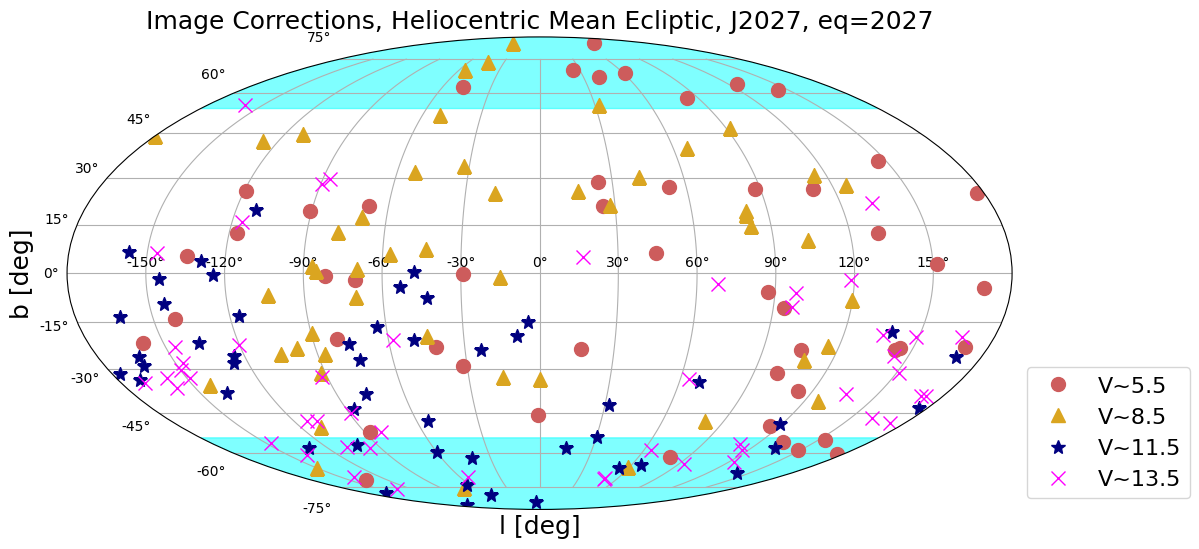

In [22]:
magList = np.array([5.5,8.5,11.5,13.5]) #Array of V magnitudes that we want to query
markers_arr = ['o','^','*','x'] #Plot markers for the sky map
markers_col = ['indianred','goldenrod','navy','magenta'] #Marker colors for plotted points
#Setting up the plot
fig1,ax1 = plt.subplots(1,1,figsize=(12,6),subplot_kw={'projection': 'mollweide'}) #This creates a Mollweide projection map
ax1.grid(True) #Grid lines
ax1.axhspan(np.deg2rad(54), np.deg2rad(90), alpha=0.5, color='cyan') #Plot out CVZs as a shaded region
ax1.axhspan(np.deg2rad(-90), np.deg2rad(-54), alpha=0.5, color='cyan')
ax1.set_title('Image Corrections, Heliocentric Mean Ecliptic, J2027, eq=2027',fontsize=18) #Set a plot title
ax1.set_xlabel('l [deg]',fontsize=18) #Set axes labels
ax1.set_ylabel('b [deg]',fontsize=18)
for i in np.arange(len(magList)):
    mag = queryTap_byVmag(magList[i])
    #The following lines fill any missing values in your table query with the numbers in parentheses
    #mag["plx_value"] = mag["plx_value"].filled(0.00001)
    #mag["pmra"] = mag["pmra"].filled(0.0)
    #mag["pmdec"] = mag["pmdec"].filled(0.0)
    #mag["rvz_radvel"] = mag["rvz_radvel"].filled(0.0)
    magDist = 1000./mag["plx_value"].value #Calculate the system distance in pc

    epochtime = astroTime('J2027',format='jyear_str') #Define epoch and equinox times for the ecliptic transformation
    equitime = astroTime(2027.0,format='decimalyear')

    ics = SkyCoord(ra=mag['ra'],dec=mag['dec'],unit=(u.deg,u.deg),frame='icrs',
		distance=magDist*u.pc,pm_ra_cosdec=mag["pmra"],pm_dec=mag["pmdec"],
		radial_velocity=mag["rvz_radvel"],obstime=astroTime('J2000',format='jyear_str')) #Set up a SkyCoord object. Requires the values from Simbad Query.

    newICS = ics.apply_space_motion(new_obstime=epochtime) #Apply proper and radial motion to the new observing time of 2027

    newECL = newICS.transform_to(HeliocentricMeanEcliptic(equinox=astroTime(2027.0,format='decimalyear'),obstime=astroTime('J2027',format='jyear_str'))) #Transform your proper motion applied ICRS coordinates to ecliptic coordinates

    ra_rad = newECL.lon.wrap_at(180 * u.deg).radian #Express your ecliptic coordinates (longitude and latitude) in radians for plotting, allow it to wrap around the projection to the other side
    dec_rad = newECL.lat.radian

    #Plot your result
    ax1.plot(ra_rad,dec_rad,marker=markers_arr[i],linestyle='None',color=markers_col[i],markersize=10,label='V~'+str(magList[i]))

    time.sleep(5) #I put this step in because if you make too many simbad queries in a given time interval, your IP gets blocked for a period of time. So every time you complete a query, wait 5 seconds before starting the next one.
    print('Completed Mag '+str(magList[i]))
#Create a plot legend
ax1.legend(bbox_to_anchor=(1.2,0),loc='lower right',fontsize=16)
fig1.tight_layout() #Clean it up
plt.show()


There you have it! You created a sky coverage map of possible image correction calibration targets that satisfy the criteria of having a certain V magnitude, having proper motions and radial velocities, and not being variable and/or double stars. TAP queries are verbose, but the verbosity helps to convey what criteria you're actually filtering for when performing a query. Stay tuned for other additions to this tutorial including querying for objects within a certain coordinate region and also querying VizieR catalogs.